In [8]:
#%% Importing modules and data
import smtplib
import pandas as pd
import numpy as np
import datetime as dt
import pandas.stats.moments as st
from pandas import ExcelWriter
import matplotlib.pyplot as plt
import os
import quandl as qd
import seaborn as sns
import matplotlib.dates as dates
import matplotlib.ticker as ticker
from pandas_datareader import data

%matplotlib inline

def save_xls(list_dfs, xls_path,sheet_names):
    writer = ExcelWriter(xls_path)
    for n, df in enumerate(list_dfs):
        df.to_excel(writer, sheet_names[n])
    writer.save()
    return

In [9]:


# Define the instruments to download. We would like to see Apple, Microsoft and the S&P500 index.
# Use site: http://optionsforum.net/topic/268/50-stocks-with-most-liquid-options
'''
tickers = ['ABT', 'ABBV', 'PNR', 'CL', 'HRL', 'CLX', 'LOW', 'PG', 'BCR', 'PEP', 'CTAS',
          'XOM', 'EMR', 'PPG', 'GWW', 'ADM', 'TGT', 'AFL', 'ED', 'MMM', 'SHW', 'CVX',
          'WBA', 'SPGI', 'JNJ', 'DOV', 'KO', 'SWK', 'CAH', 'MCD', 'APD', 'FRT', 'VFC',
          'KMB', 'WMT', 'BDX', 'GPC', 'ADP', 'LEG', 'TROW', 'ECL', 'CINF', 'MDT', 'MKC',
          'ITW', 'BEN', 'NUE', 'SYY', 'T', 'GD']
'''
tickers = pd.read_csv('list.csv')
tickers = list(tickers['Ticker'])
#tickers = ['HYG']
# Define which online source one should use
data_source = 'google'

# We would like all available data from 01/01/2000 until 12/31/2016.
start_date = '2007-01-01'
end_date = '2017-11-01'

start = dt.datetime(2007, 1, 1)
end = dt.datetime.today()

# User pandas_reader.data.DataReader to load the desired data. As simple as that.
panel_data = data.DataReader(tickers, data_source, start, end)

# panel_data.minor_xs('SPY')

# Getting just the adjusted closing prices. This will return a Pandas DataFrame
# The index in this DataFrame is the major index of the panel_data.
close = panel_data.ix['Close']

# Getting all weekdays between start_date and end_date
#all_weekdays = pd.date_range(start=start_date, end=end_date, freq='B')

# How do we align the existing prices in adj_close with our new set of dates?
# All we need to do is reindex close using all_weekdays as the new index
#close = close.reindex(all_weekdays)


C:\Users\Fang\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


In [10]:
# Function for calculating standard dev and price moves in terms of standard dev
# DF[[Adj Close]] Rolling Period --> DF[['Daily Vol','Daily Price Vol','Price Dev','Annual Vol']]
def price_devs(close_prices,roll_period,plot_window, hist_window,ticker):
    df = close_prices.copy()
    df.columns = ['prices']
    df['prices_delta'] = df.prices - df.prices.shift(1)
    df['log_returns'] = np.log(df.prices) - np.log(df.prices.shift(1))
    df['daily_vol'] = st.rolling_std(df.log_returns, roll_period, ddof = 1)
    df['daily_vol_dollar'] = df.daily_vol*df.prices
    df['price_dev'] = df.prices_delta/df.daily_vol_dollar.shift(1)
    df['annual_vol'] = df.daily_vol*np.sqrt(252)
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (20,10))
    
    df['price_dev'].tail(plot_window).plot(kind = 'bar',ax=axes[0,0], rot=20)
    
    # Make most of the ticklabels empty so the labels don't get too crowded
    ticklabels = ['']*len(df.tail(plot_window).index)
    # Every ith ticklable shows the month and day
    i = int(plot_window/10)
    ticklabels[::i] = [item.strftime('%b %d %Y') for item in df.tail(plot_window).index[::i]]
    # Every jth ticklabel includes the year
    j = i
    ticklabels[::j] = [item.strftime('%b %d\n%Y') for item in df.tail(plot_window).index[::j]]
    #axes[0,0].xaxis.set_major_formatter(ticker.FormatStrFormatter(ticklabels))
    axes[0,0].set_xlabel('')
    axes[0,0].set_xticklabels(ticklabels)
    
    df.tail(hist_window).price_dev.hist(bins = 20,ax=axes[0,1])
    df.tail(hist_window)[df.price_dev < 0].price_dev.hist(bins = 10,ax=axes[1,0])
    df.tail(hist_window)[df.price_dev >= 0].price_dev.hist(bins = 10,ax=axes[1,1])
    
    axes[0,0].set_title('Period Price Deviations')
    axes[0,1].set_title('Distribution of Price Deviations')
    axes[1,0].set_title('Left-Side Distribution')
    axes[1,1].set_title('Right-Side Distribution')
    fig.suptitle(ticker,fontsize=20)
    print(df.tail(5))
    return df

In [11]:
def vol_summary(adj_c_df,rolling_period,lookback_window,hist_window,ticker):
    etf = price_devs(adj_c_df,rolling_period,lookback_window,hist_window,ticker)
    
    # Describing Deviation Data
    obs = hist_window

    #print(etf.price_dev.tail(obs).describe())#percentiles = list(np.arange(0.1,1,0.1))))
    print('---------------------')
    # Finding date of largest drop
    print('Date of largest drop')
    print(etf.price_dev.tail(obs).iloc[etf.price_dev.tail(obs).index.get_loc(etf.price_dev.tail(obs).idxmin())])
    print(etf.price_dev.tail(obs).idxmin())
    print('---------------------')
    # Finding date of largest spike
    print('Date of largest spike')
    print(etf.price_dev.tail(obs).iloc[etf.price_dev.tail(obs).index.get_loc(etf.price_dev.tail(obs).idxmax())])
    print(etf.price_dev.tail(obs).idxmax())
    print('---------------------')
    # Histogram Bins
    d = {'Std Bins':np.histogram(etf.price_dev.tail(obs), 40, (-20,20))[1][:-1],
        'Frequency':np.histogram(etf.price_dev.tail(obs), 40, (-20,20))[0]}
    df = pd.DataFrame(d,index = d['Std Bins'])[['Frequency']]
    #print(df)
    return df

C:\Users\Fang\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=4,center=False).std(ddof=1)
  


            prices  prices_delta  log_returns  daily_vol  daily_vol_dollar  \
Date                                                                         
2017-10-30   28.91         -0.22    -0.007581   0.006550          0.189358   
2017-10-31   28.60         -0.31    -0.010781   0.006632          0.189684   
2017-11-01   29.43          0.83     0.028608   0.018947          0.557611   
2017-11-02   29.53          0.10     0.003392   0.017862          0.527454   
2017-11-03   29.42         -0.11    -0.003732   0.017162          0.504911   

            price_dev  annual_vol  
Date                               
2017-10-30  -0.538052    0.103977  
2017-10-31  -1.637109    0.105285  
2017-11-01   4.375692    0.300775  
2017-11-02   0.179337    0.283545  
2017-11-03  -0.208549    0.272441  
---------------------
Date of largest drop
-14.2832854573
2017-05-18 00:00:00
---------------------
Date of largest spike
9.12953716414
2017-03-13 00:00:00
---------------------


C:\Users\Fang\Anaconda3\lib\site-packages\numpy\lib\function_base.py:747: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
C:\Users\Fang\Anaconda3\lib\site-packages\numpy\lib\function_base.py:748: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


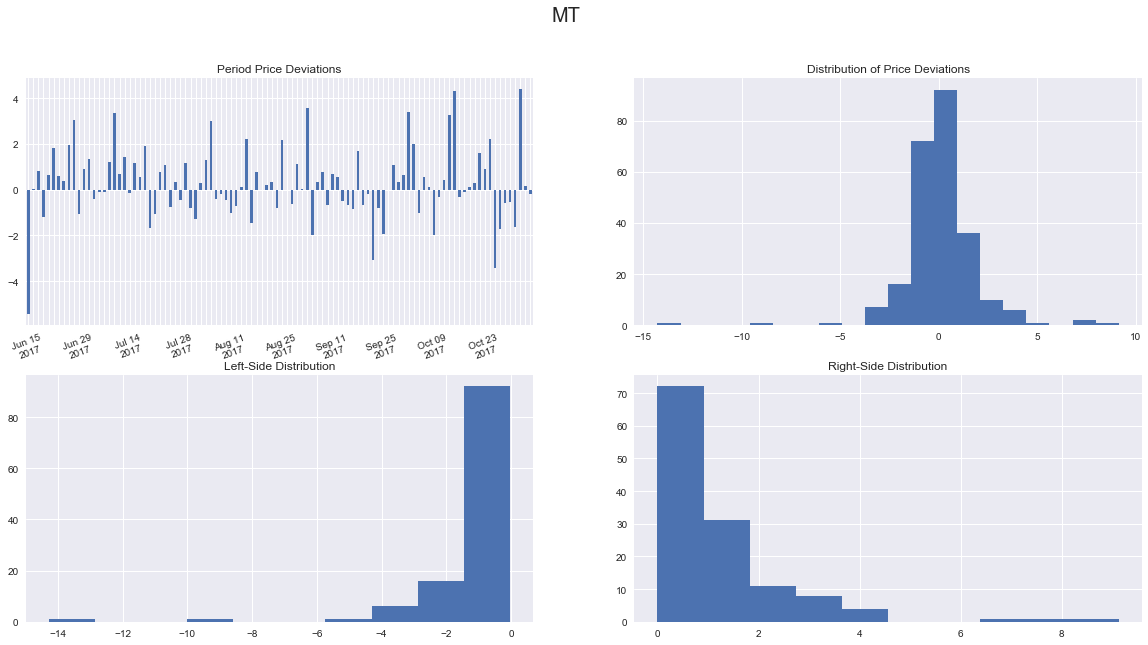

In [9]:
rolling_period = 4
lookback_window = 100
hist_window = 500
ticker = 'MT'
stock = vol_summary(close[[ticker]],rolling_period,lookback_window,hist_window,ticker)

C:\Users\Fang\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=4,center=False).std(ddof=1)
  


            prices  prices_delta  log_returns  daily_vol  daily_vol_dollar  \
Date                                                                         
2017-11-01   73.31          0.40     0.005471   0.009737          0.713787   
2017-11-02   73.15         -0.16    -0.002185   0.009217          0.674251   
2017-11-03   72.80         -0.35    -0.004796   0.011115          0.809187   
2017-11-06   72.18         -0.62    -0.008553   0.005932          0.428138   
2017-11-07   73.09          0.91     0.012529   0.009231          0.674697   

            price_dev  annual_vol  
Date                               
2017-11-01   0.551730    0.154563  
2017-11-02  -0.224157    0.146321  
2017-11-03  -0.519095    0.176448  
2017-11-06  -0.766201    0.094160  
2017-11-07   2.125482    0.146538  
---------------------
Date of largest drop
-7.15592006073
2016-11-21 00:00:00
---------------------
Date of largest spike
10.090276359
2017-09-29 00:00:00
---------------------


C:\Users\Fang\Anaconda3\lib\site-packages\numpy\lib\function_base.py:747: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
C:\Users\Fang\Anaconda3\lib\site-packages\numpy\lib\function_base.py:748: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


            prices  prices_delta  log_returns  daily_vol  daily_vol_dollar  \
Date                                                                         
2017-11-01   47.55          0.81     0.017181   0.004914          0.233682   
2017-11-02   47.34         -0.21    -0.004426   0.009382          0.444143   
2017-11-03   48.96          1.62     0.033648   0.016117          0.789078   
2017-11-06   50.35          1.39     0.027995   0.016802          0.845983   
2017-11-07   50.19         -0.16    -0.003183   0.020131          1.010350   

            price_dev  annual_vol  
Date                               
2017-11-01   3.939821    0.078015  
2017-11-02  -0.898656    0.148934  
2017-11-03   3.647472    0.255846  
2017-11-06   1.761550    0.266724  
2017-11-07  -0.189129    0.319562  
---------------------
Date of largest drop
-7.43690619942
2017-08-07 00:00:00
---------------------
Date of largest spike
6.32241318287
2017-03-29 00:00:00
---------------------
            prices  pri

            prices  prices_delta  log_returns  daily_vol  daily_vol_dollar  \
Date                                                                         
2017-11-01   55.71         -0.72    -0.012841   0.014482          0.806781   
2017-11-02   56.26          0.55     0.009824   0.013328          0.749832   
2017-11-03   56.55          0.29     0.005141   0.010700          0.605095   
2017-11-06   56.33         -0.22    -0.003898   0.010037          0.565412   
2017-11-07   56.47          0.14     0.002482   0.005727          0.323417   

            price_dev  annual_vol  
Date                               
2017-11-01  -0.994120    0.229891  
2017-11-02   0.681721    0.211575  
2017-11-03   0.386753    0.169860  
2017-11-06  -0.363579    0.159340  
2017-11-07   0.247607    0.090917  
---------------------
Date of largest drop
-12.775044495
2016-12-01 00:00:00
---------------------
Date of largest spike
9.01001332084
2017-10-06 00:00:00
---------------------


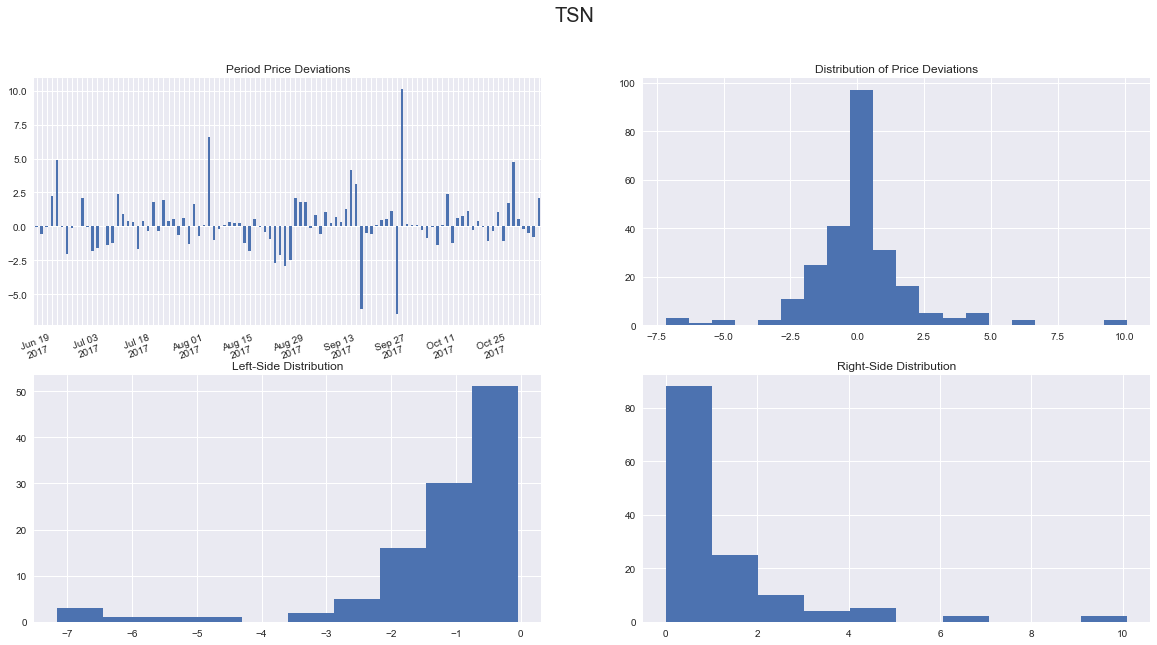

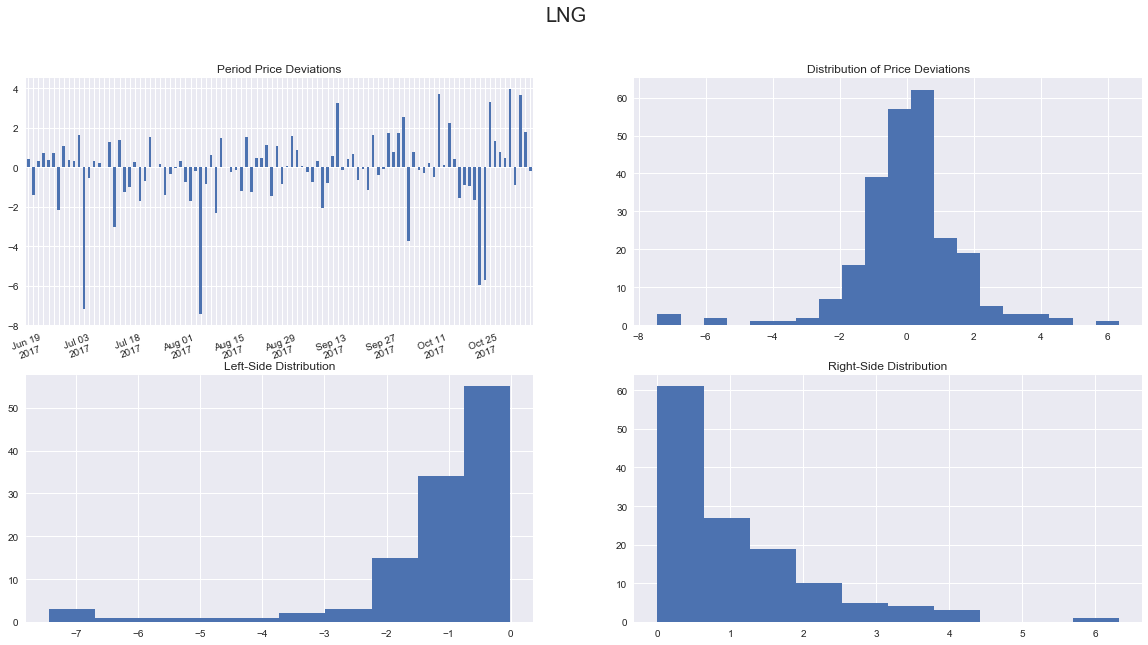

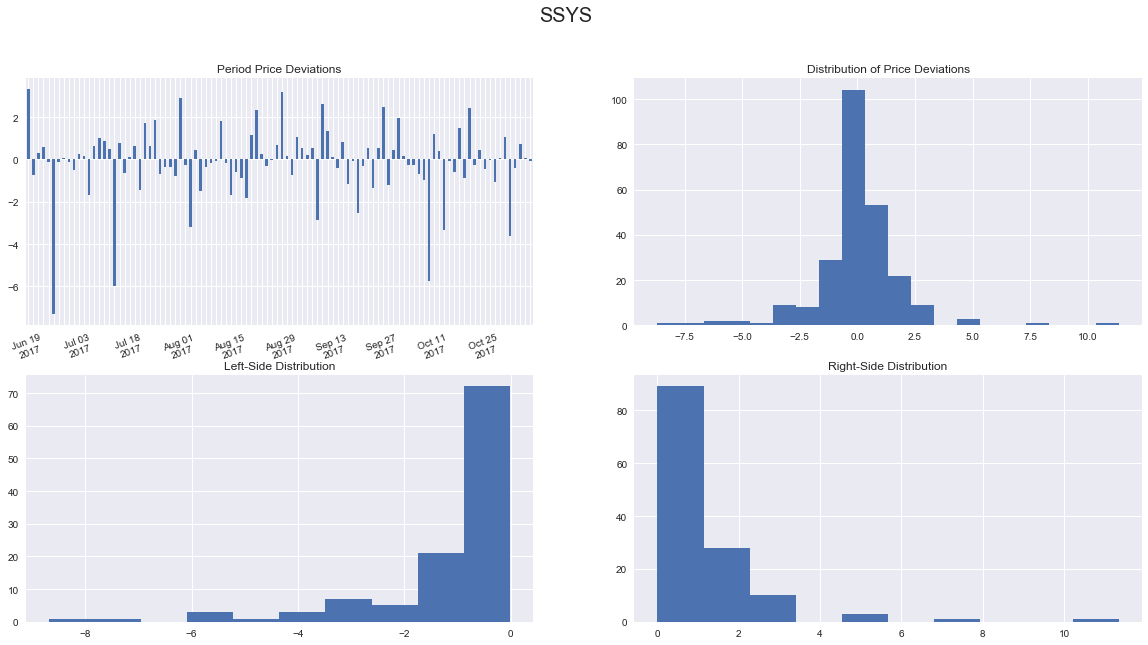

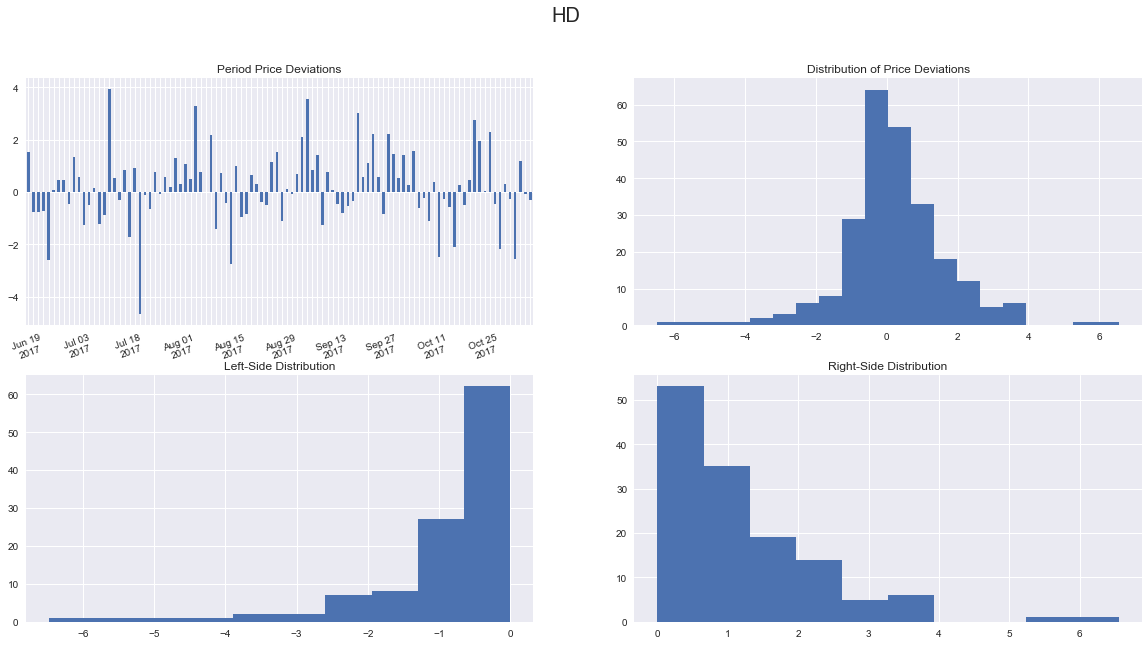

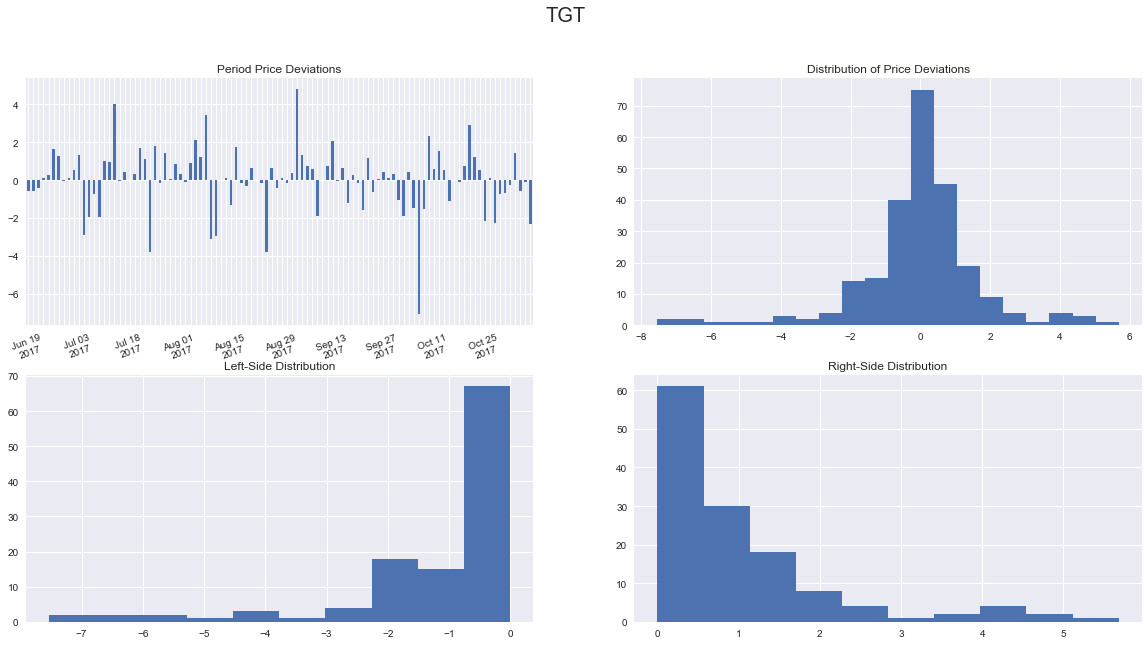

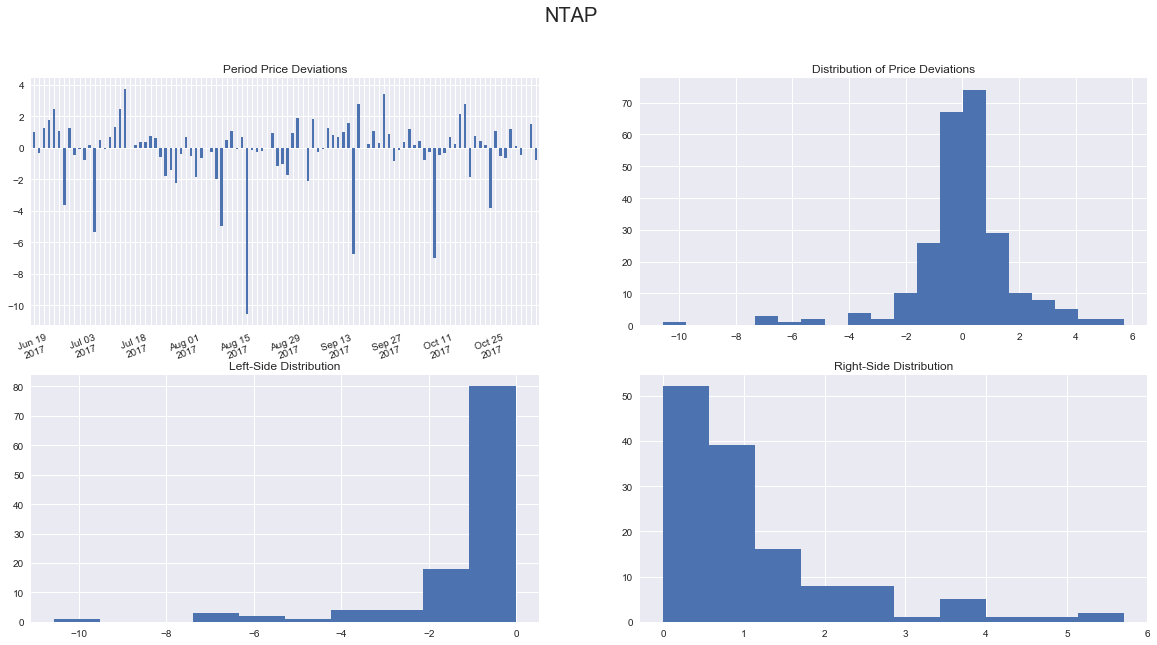

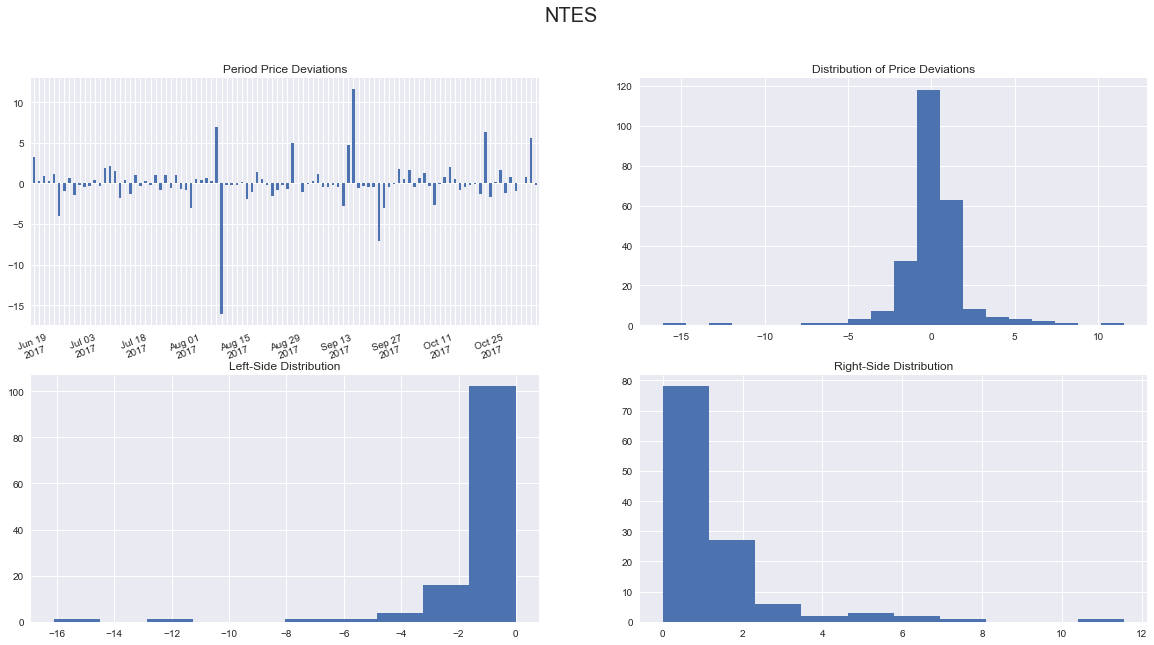

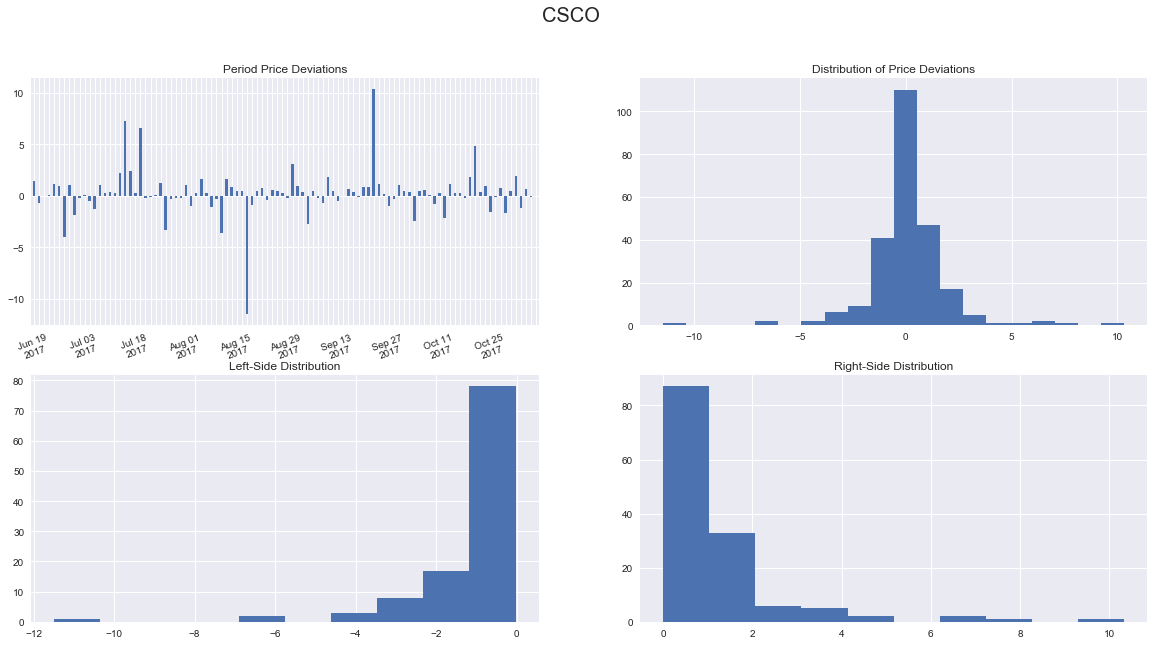

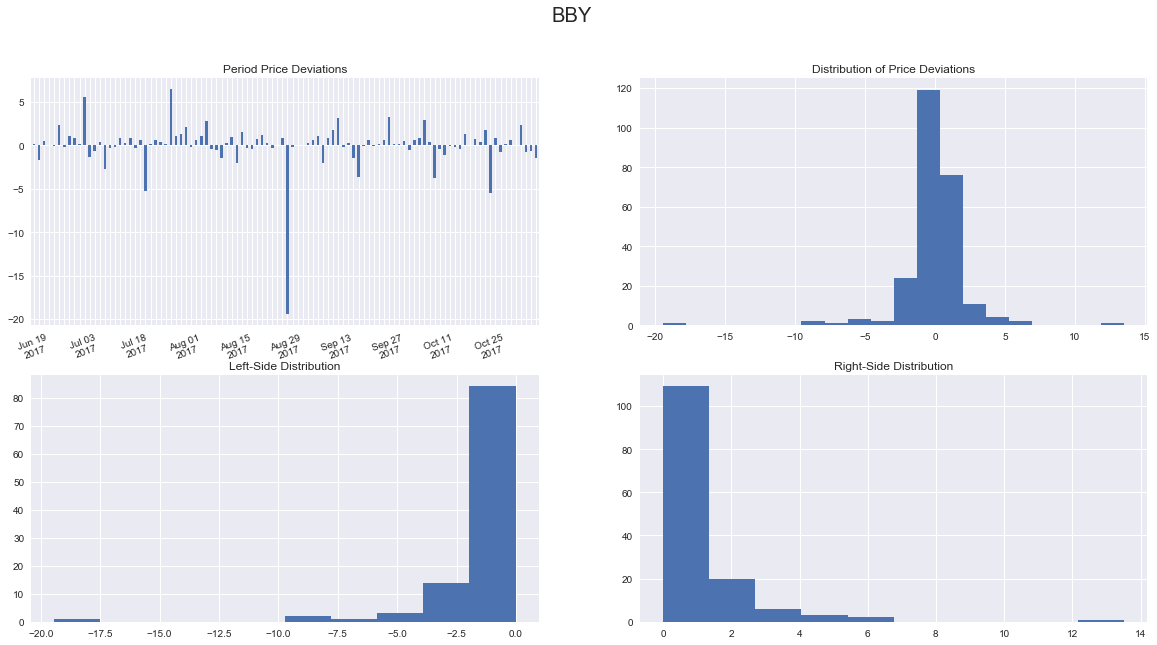

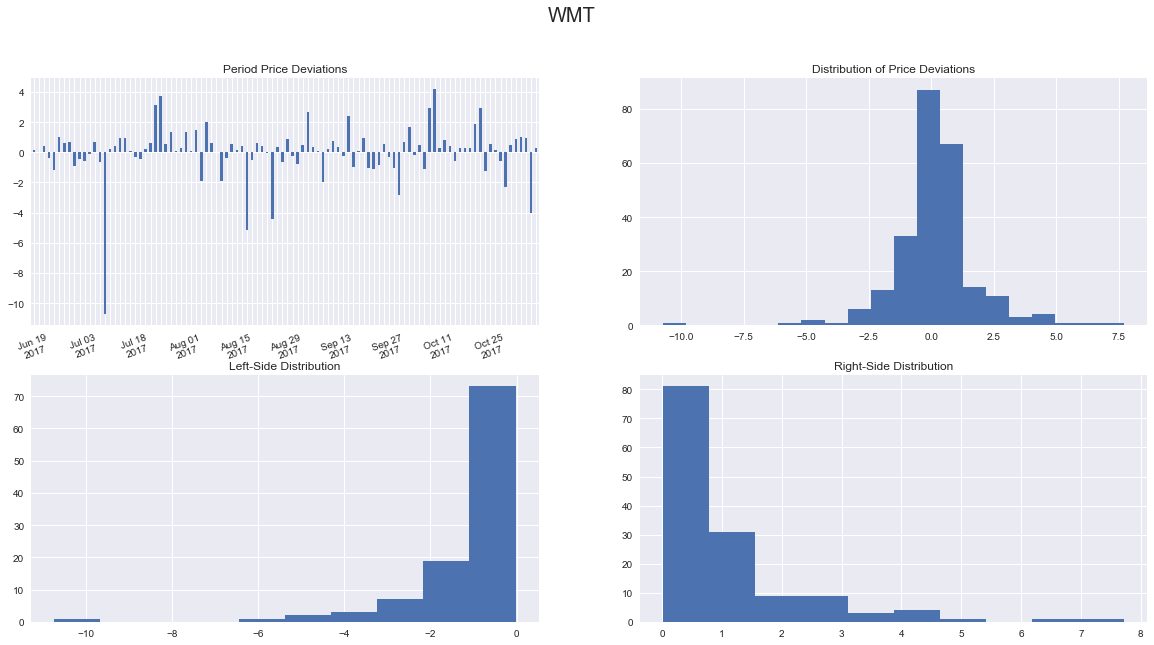

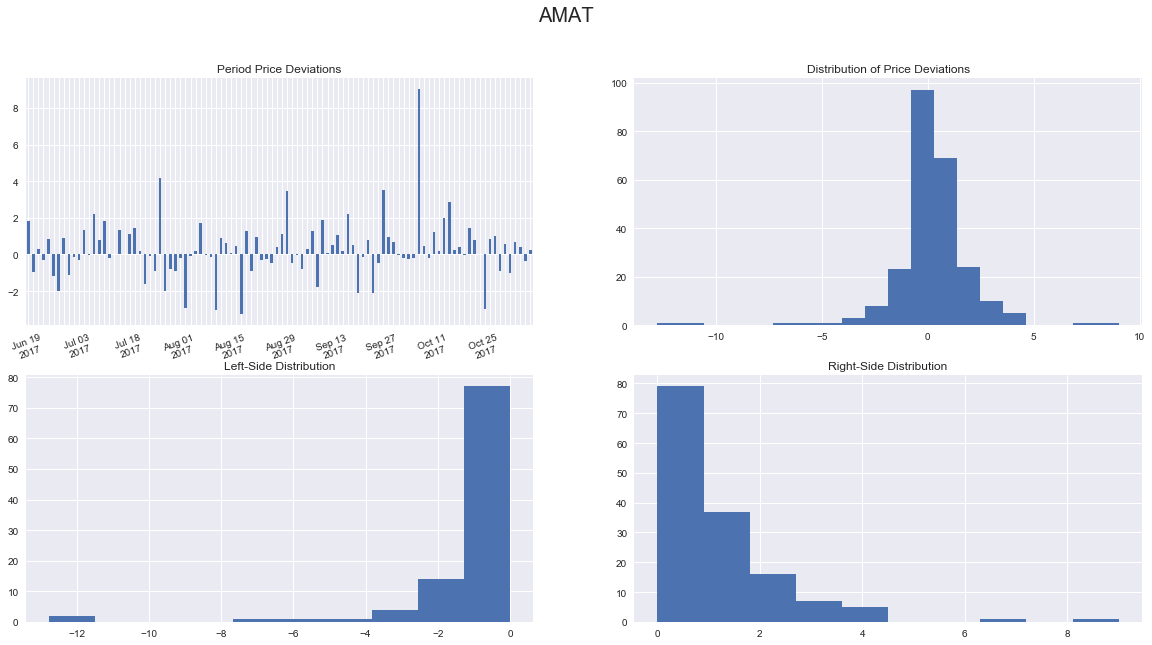

In [12]:
rolling_period = 4
lookback_window = 100
hist_window = 500
for ticker in tickers:
    stock = vol_summary(close[[ticker]],rolling_period,lookback_window,hist_window,ticker)

In [33]:
dic = {}
clse = []
tkers = []
for ticker in tickers:
    clse = clse + [close[[ticker]].iloc[-1][ticker]]
    tkers = tkers + [ticker]
    
dic['Close'] = clse
dic['Ticker'] = tkers
pd.DataFrame(dic)

,Close,Ticker
0,69.25,CVS
1,47.62,KORS
2,35.72,MYL
3,1894.49,PCLN
4,13.08,THC
5,38.88,TRIP
6,44.68,WTW
7,113.19,SWKS
8,64.10,EMR
9,54.16,IONS
